# Tutorial 7: Vertical integration

In this tutorial, we demonstrate how to analyse multiple tissue slices in vertical integration. Here we take four DLPFC slices (151673, 151674, 151675, and 151676) as example. Before running the model, please download the input data via https://zenodo.org/record/8185216/files/DLPFC.rar?download=1.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import time
import torch
import stGCL as stGCL
from stGCL.process import prefilter_genes,prefilter_specialgenes,set_seed,refine_nearest_labels,vertical_alignment
os.environ['R_HOME'] = '/home/dell/anaconda3/envs/stjupyter/lib/R'
from stGCL import train_model
from stGCL.utils import mclust_R, Cal_Spatial_Net,Cal_3D_Spatial_Net

In [2]:
radius = 50
top_genes = 3000
epoch = 3000
rad_cutoff=150
seed = 0
set_seed(seed)
distance_short=17.5
distance_long=700
k=7

## Vertical alignment

In [3]:
dataset = [ "151673", "151674", "151675", "151676"]
print("loading data",dataset,k)
list_adata=[]

loading data ['151673', '151674', '151675', '151676'] 7


In [4]:
for section_id in dataset:
    im_re = pd.read_csv(os.path.join("/home/dell/stproject/stGCL/Data/DLPFC/{}/image_representation/ViT_pca_representation.csv".
                    format(section_id)),header=0, index_col=0,sep=',')
    adata = sc.read_visium(path="/home/dell/stproject/stGCL/Data/DLPFC/{}".format(section_id), 
                           count_file='{}_filtered_feature_bc_matrix.h5'.format(section_id))
    adata.obsm["im_re"] = im_re
    spatial = pd.read_csv('/home/dell/stproject/stGCL/Data/DLPFC/{}/spatial/tissue_positions_list.csv'.format(section_id), 
                          sep=",", header=None,na_filter=False, index_col=0)
    adata.obs["x_array"]=spatial[2]
    adata.obs["y_array"]=spatial[3]
    adata.obs["x_pixel"]=spatial[5]
    adata.obs["y_pixel"]=spatial[4]*-1
    adata.obs["z_pixel"]=0
    adata.var_names_make_unique()
    Ann_df = pd.read_csv('/home/dell/stproject/stGCL/Data/DLPFC/{}/cluster_labels_{}.csv'.format(section_id, section_id),
                         sep=',', header=0,index_col=0)
    adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
    num_to_layer = {
        1: "Layer 1",
        2: "Layer 2",
        3: "Layer 3",
        4: "Layer 4",
        5: "Layer 5",
        6: "Layer 6",
        7: "WM",
    }
    adata.obs['ground_truth'] = adata.obs['ground_truth'].map(num_to_layer)
    list_adata.append(adata)

7008.05880736466 7008.058807364816


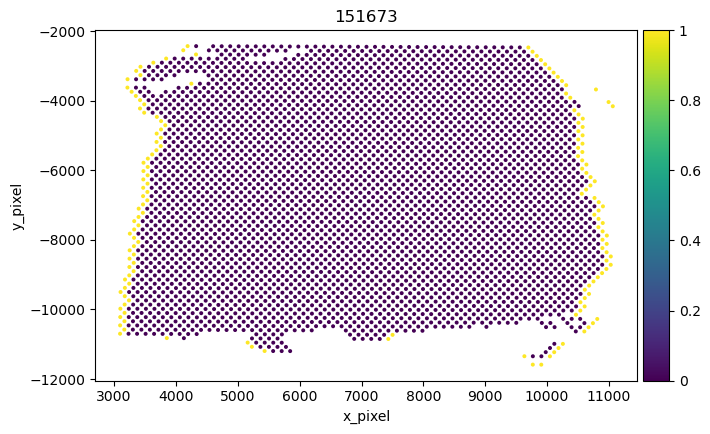

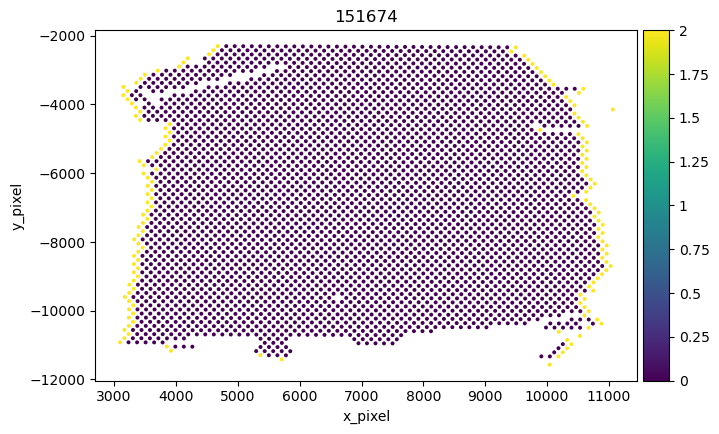

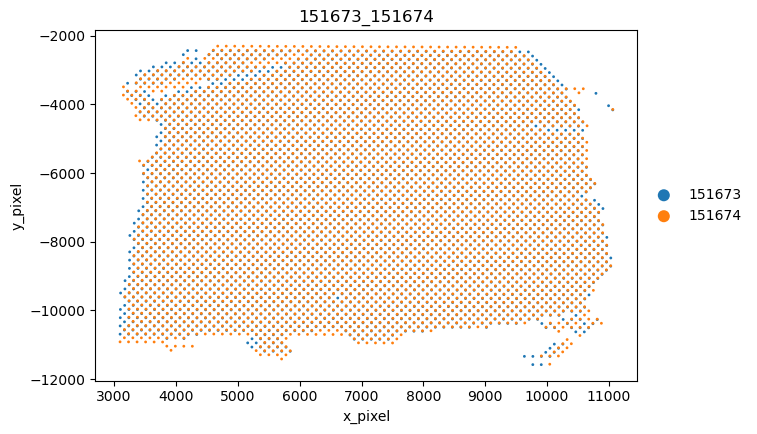

6922.372494432071 6922.372494431804


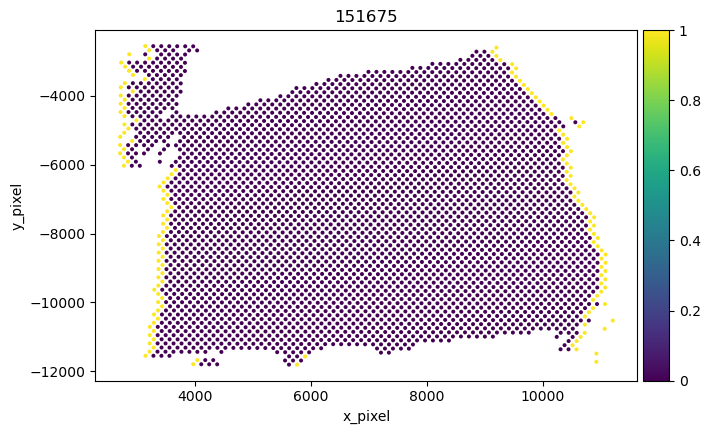

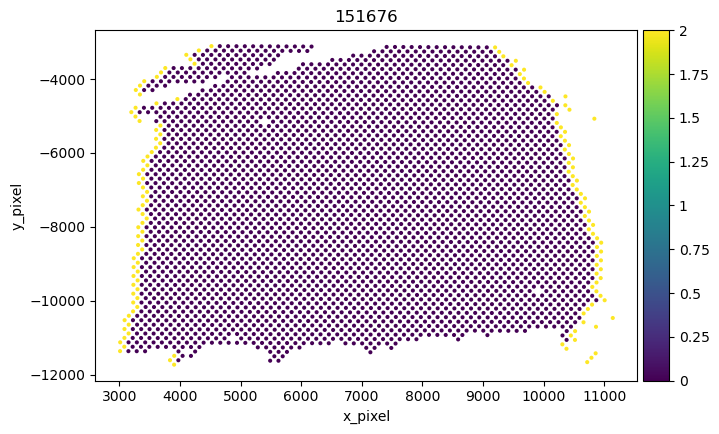

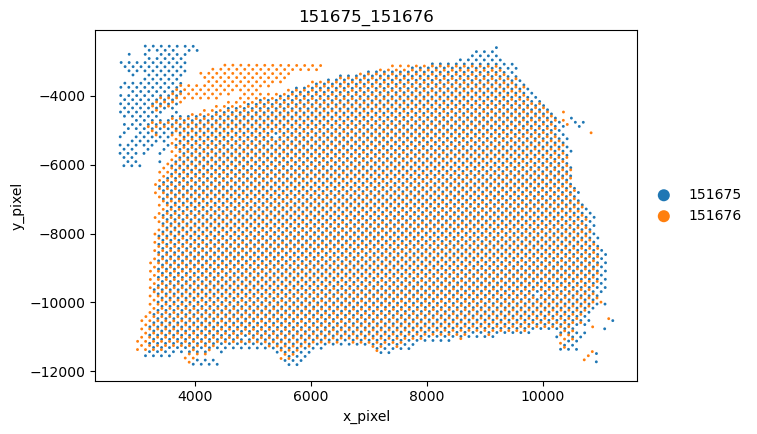

7008.058807365204 6922.372494432988


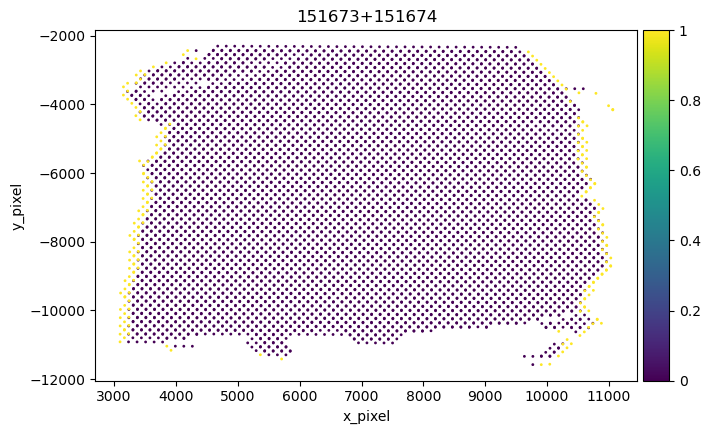

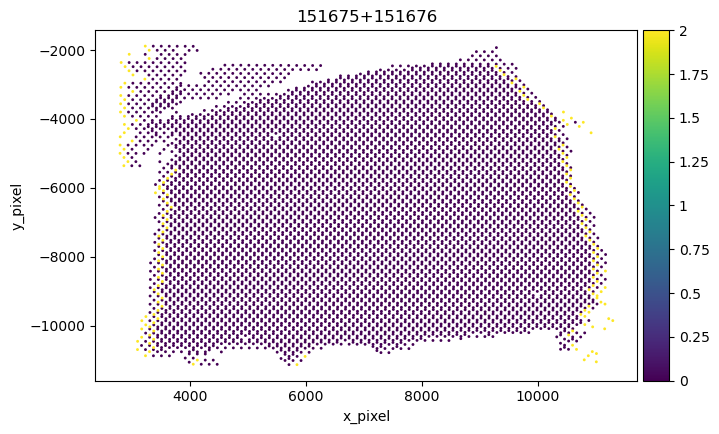

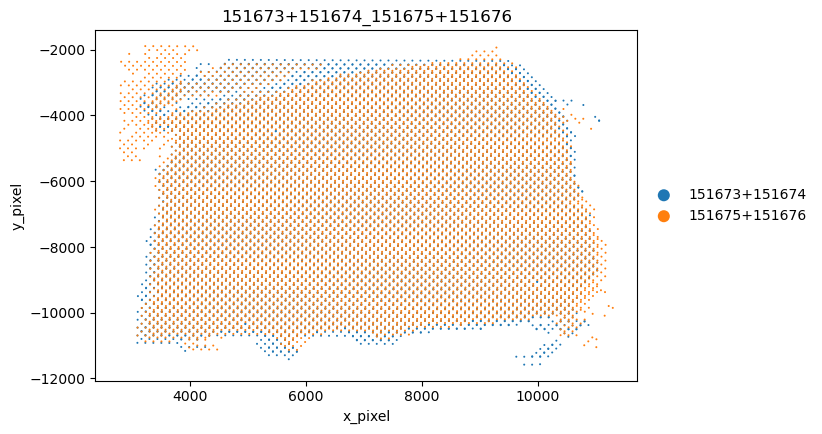

In [13]:
%matplotlib inline
adata12=vertical_alignment(list_adata[0],list_adata[1],z=distance_short,batch_categories=[dataset[0],dataset[1]], 
                           batch_key="dataset_batch")
adata34 = vertical_alignment(list_adata[2], list_adata[3], z=distance_short, batch_categories=[dataset[2], dataset[3]], 
                             batch_key="dataset_batch")
adata_all = vertical_alignment(adata12, adata34, z=distance_long, batch_categories=[dataset[0]+"+"+dataset[1], 
                                    dataset[2]+"+"+dataset[3]], batch_key="double_dataset_batch")

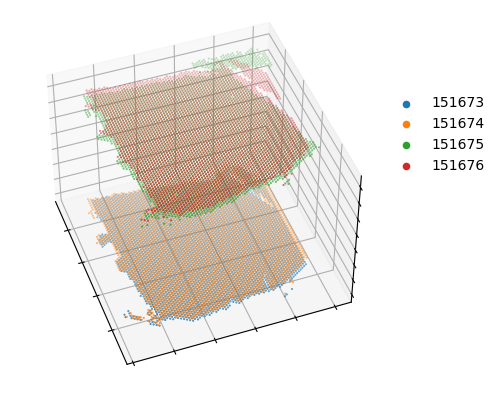

In [6]:
section_colors = ['#02899A', '#0E994D', '#86C049', '#FBB21F', '#F48022', '#DA5326', '#BA3326']
ax1 = plt.axes(projection='3d')
for section in dataset:
    temp_Coor = adata_all.obs[adata_all.obs["dataset_batch"]==section]
    temp_xd = temp_Coor["x_pixel"]
    temp_yd = temp_Coor["y_pixel"]
    temp_zd = temp_Coor["z_pixel"]
    ax1.scatter3D(temp_xd, temp_yd, temp_zd, s=0.2, marker="o", label=section)

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
plt.legend(bbox_to_anchor=(1,0.8), markerscale=10, frameon=False)

ax1.elev = 45
ax1.azim = -20
plt.show()

In [7]:
prefilter_genes(adata_all, min_cells=3)  # avoiding all genes are zeros
prefilter_specialgenes(adata_all)
sc.pp.highly_variable_genes(adata_all, flavor="seurat_v3", n_top_genes=top_genes)
sc.pp.normalize_total(adata_all, target_sum=1e4)
sc.pp.log1p(adata_all)
sc.pp.scale(adata_all, zero_center=False, max_value=10)

## Constructing the 3D spatial network and Running model

In [8]:
Cal_3D_Spatial_Net(adata_all, rad_cutoff=rad_cutoff)

In [9]:
adata_all = train_model.train(adata_all, k,  n_epochs=epoch, use_image=True,single=False)

train with image
Epoch:100 loss:0.726
Epoch:200 loss:0.70475
Epoch:300 loss:0.69712
Epoch:400 loss:0.69065
Epoch:500 loss:0.68797
Epoch:600 loss:0.68673
Epoch:700 loss:0.68882
Epoch:800 loss:0.68629
Epoch:900 loss:0.68589
Epoch:1000 loss:0.69479
Epoch:1100 loss:0.6865
Epoch:1200 loss:0.68631
Epoch:1300 loss:0.68605
Epoch:1400 loss:0.6858
Epoch:1500 loss:0.68575
Epoch:1600 loss:0.71431
Epoch:1700 loss:0.68605
Epoch:1800 loss:0.68593
Epoch:1900 loss:0.68578
Epoch:2000 loss:0.68785
Epoch:2100 loss:0.68584
Epoch:2200 loss:0.68572
Epoch:2300 loss:0.68589
Epoch:2400 loss:0.68581
Epoch:2500 loss:0.68549
Epoch:2600 loss:0.68789
Epoch:2700 loss:0.6865
Epoch:2800 loss:0.68847
Epoch:2900 loss:0.68626
Epoch:3000 loss:0.68586


In [10]:
adata_all = mclust_R(adata_all, used_obsm='stGCL', num_cluster=k)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [11]:
dfobs=adata_all.obs.dropna()
for i in range(len(dataset)):
    print("section {} result-------------- ".format(dataset[i]))
    obs1 = dfobs[dfobs["dataset_batch"] == dataset[i]]
    ARI = adjusted_rand_score(obs1['mclust'], obs1['ground_truth'])
    print('Adjusted rand index = %.2f' % ARI)
print("------------------------------------------")
ARI = adjusted_rand_score(dfobs['mclust'], dfobs['ground_truth'])
print('overall Adjusted rand index = %.2f' % ARI)

section 151673 result-------------- 
Adjusted rand index = 0.57
section 151674 result-------------- 
Adjusted rand index = 0.66
section 151675 result-------------- 
Adjusted rand index = 0.65
section 151676 result-------------- 
Adjusted rand index = 0.62
------------------------------------------
overall Adjusted rand index = 0.62


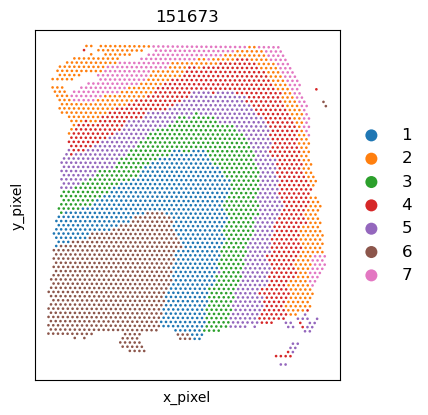

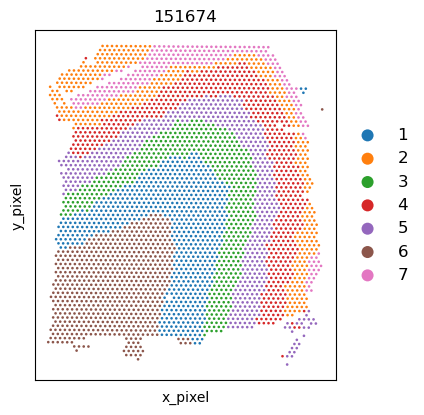

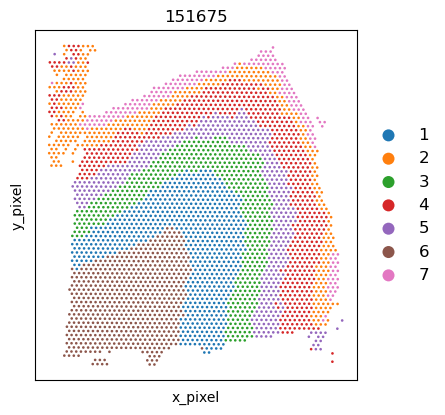

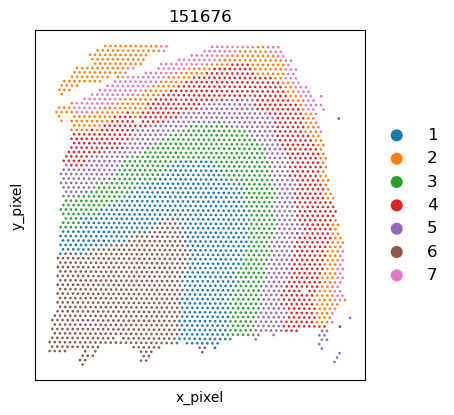

In [12]:
for id in dataset:
    used_adata = adata_all[adata_all.obs['dataset_batch']==id,]
    ax = sc.pl.scatter(used_adata, alpha=1, x="x_pixel", y="y_pixel", color="mclust",  legend_fontsize=12, show=False,title=id,
                           size=50000 / adata.shape[0])
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])